In [60]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

In [1]:
# ChatGPTed examples, might be completely inaccurate, but doesn't matter for demo purposes
INDISTINGUISHABLE_FIRST_NAMES = {
    'SC-ST': ['Abhi', 'Biru', 'Daru', 'Gelu', 'Jitu', 'Kalia', 'Litu', 'Mangu'],
    'SC-Other': ['Amar', 'Biren', 'Dinanath', 'Gopal', 'Jagan', 'Kailash', 'Laxman', 'Madan'],
    'ST-Other': ['Arjun', 'Bhola', 'Dhiren', 'Ganesh', 'Jhantu', 'Kishore', 'Lakhan', 'Mohan']
}

INDISTINGUISHABLE_LAST_NAMES = {
    'SC-ST': ['Bariha', 'Dangria', 'Gagrai', 'Janha', 'Kisku', 'Lakra', 'Marandi', 'Soren'],
    'SC-Other': ['Behera', 'Das', 'Jena', 'Mahanta', 'Nayak', 'Panda', 'Rout', 'Sahu'],
    'ST-Other': ['Barla', 'Dehuri', 'Hembram', 'Kisan', 'Munda', 'Purti', 'Tirkey', 'Xalxo']
}

In [42]:
def calculate_stats(results_test, results_pred, name, display_labels):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    if len(display_labels) > 2:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, average='weighted')
        recall = recall_score(results_test, results_pred, average='weighted')
        f1 = f1_score(results_test, results_pred, average='weighted')
    else:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred)
        recall = recall_score(results_test, results_pred)
        f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)


In [61]:
def visualize_embeddings(X, y, n_samples=10000, method='tsne'):
    
    if len(X) > n_samples:
        idx = np.random.choice(len(X), n_samples, replace=False)
        X_sample = X[idx]
        y_sample = y[idx]
    else:
        X_sample = X
        y_sample = y
    
    if method == 'tsne':
        # Use t-SNE for dimensionality reduction
        reducer = TSNE(n_components=3, random_state=42)
    else:
        # Use PCA as fallback
        reducer = PCA(n_components=3)
    
    embeddings = reducer.fit_transform(X_sample)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    unique_classes = np.unique(y_sample)
    colors = sns.color_palette("husl", len(unique_classes))
    
    for i, cls in enumerate(unique_classes):
        mask = (y_sample == cls)
        ax.scatter(embeddings[mask, 0], embeddings[mask, 1], embeddings[mask, 2],
                   color=colors[i], label=cls, alpha=0.6)
    
    ax.set_title('3D Visualization of Name Embeddings')
    ax.legend()
    plt.show()
    
    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(unique_classes):
        mask = (y_sample == cls)
        plt.scatter(embeddings[mask, 0], embeddings[mask, 1],
                    color=colors[i], label=cls, alpha=0.6)
    
    plt.title('2D Visualization of Name Embeddings')
    plt.legend()
    plt.show()

In [43]:
def preprocess_name(name):
    parts = name.strip().split()
    first_name = parts[0].lower() if len(parts) > 0 else ""
    last_name = parts[-1].lower() if len(parts) > 1 else ""
    
    f4_first = first_name[:4] if len(first_name) >= 4 else first_name
    l4_first = first_name[-4:] if len(first_name) >= 4 else first_name
    f4_last = last_name[:4] if len(last_name) >= 4 else last_name
    l4_last = last_name[-4:] if len(last_name) >= 4 else last_name
    
    n_sub_names = len(parts)
    has_dash = any('-' in part for part in parts)
    
    return {
        'first_name': first_name,
        'last_name': last_name,
        'f4_first': f4_first,
        'l4_first': l4_first,
        'f4_last': f4_last,
        'l4_last': l4_last,
        'n_sub_names': min(n_sub_names, 4),
        'has_dash': int(has_dash)
    }


In [44]:
def build_name_stats(df, name_col='name', ethnicity_col='ethnicity'):
    first_name_stats = defaultdict(lambda: defaultdict(int))
    last_name_stats = defaultdict(lambda: defaultdict(int))
    f4_first_stats = defaultdict(lambda: defaultdict(int))
    l4_first_stats = defaultdict(lambda: defaultdict(int))
    f4_last_stats = defaultdict(lambda: defaultdict(int))
    l4_last_stats = defaultdict(lambda: defaultdict(int))
    
    for _, row in df.iterrows():
        name_info = preprocess_name(row[name_col])
        ethnicity = row[ethnicity_col]
        
        first_name_stats[name_info['first_name']][ethnicity] += 1
        last_name_stats[name_info['last_name']][ethnicity] += 1
        f4_first_stats[name_info['f4_first']][ethnicity] += 1
        l4_first_stats[name_info['l4_first']][ethnicity] += 1
        f4_last_stats[name_info['f4_last']][ethnicity] += 1
        l4_last_stats[name_info['l4_last']][ethnicity] += 1
    
    return {
        'first_name_stats': first_name_stats,
        'last_name_stats': last_name_stats,
        'f4_first_stats': f4_first_stats,
        'l4_first_stats': l4_first_stats,
        'f4_last_stats': f4_last_stats,
        'l4_last_stats': l4_last_stats
    }


In [45]:
def create_features(name, stats, cats=['SC', 'ST', 'Other']):
    name_info = preprocess_name(name)
    features = {}
    
    for eth in cats:
        fn_counts = stats['first_name_stats'][name_info['first_name']]
        total_fn = sum(fn_counts.values())
        features[f'probability_{eth}_first_name'] = fn_counts.get(eth, 0) / (total_fn + 1)
        
        ln_counts = stats['last_name_stats'][name_info['last_name']]
        total_ln = sum(ln_counts.values())
        features[f'probability_{eth}_last_name'] = ln_counts.get(eth, 0) / (total_ln + 1)
        
        f4f_counts = stats['f4_first_stats'][name_info['f4_first']]
        total_f4f = sum(f4f_counts.values())
        features[f'probability_{eth}_first_name_f4'] = f4f_counts.get(eth, 0) / (total_f4f + 1)
        
        l4f_counts = stats['l4_first_stats'][name_info['l4_first']]
        total_l4f = sum(l4f_counts.values())
        features[f'probability_{eth}_first_name_l4'] = l4f_counts.get(eth, 0) / (total_l4f + 1)
        
        f4l_counts = stats['f4_last_stats'][name_info['f4_last']]
        total_f4l = sum(f4l_counts.values())
        features[f'probability_{eth}_last_name_f4'] = f4l_counts.get(eth, 0) / (total_f4l + 1)
        
        l4l_counts = stats['l4_last_stats'][name_info['l4_last']]
        total_l4l = sum(l4l_counts.values())
        features[f'probability_{eth}_last_name_l4'] = l4l_counts.get(eth, 0) / (total_l4l + 1)
        
        features[f'best_evidence_{eth}'] = max(
            features[f'probability_{eth}_first_name'],
            features[f'probability_{eth}_last_name']
        )
    
    features['dash_indicator'] = name_info['has_dash']
    features['n_sub_names'] = name_info['n_sub_names']
    
    return features


In [57]:
def is_indistinguishable(name, stats, threshold=0.15):
    
    name_info = preprocess_name(name)
    features = create_features(name, stats)
    
    cats = sorted(stats['first_name_stats'][name_info['first_name']].keys())
    psi = {cat: features[f'probability_{cat}_first_name'] for cat in cats}
    phi = {cat: features[f'probability_{cat}_last_name'] for cat in cats}
    
    indistinguishable_pairs = []
    
    for i, r1 in enumerate(cats):
        for r2 in cats[i+1:]:
            
            condition1 = (abs(psi[r1] - psi[r2]) <= threshold and 
                         abs(phi[r1] - phi[r2]) <= threshold)
            
            max_psi = max(psi.values())
            max_phi = max(phi.values())
            condition2 = (max_psi - min(psi[r1], psi[r2]) <= threshold and 
                         max_phi - min(phi[r1], phi[r2]) <= threshold)
            
            if condition1 and condition2:
                indistinguishable_pairs.append(f"{r1}-{r2}")
    
    return indistinguishable_pairs if indistinguishable_pairs else None


In [59]:
def handle_indistinguishables(df, stats, name_col='head_of_hh'):
    
    df['indistinguishable'] = None
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        name = row[name_col]
        indistinguishable = is_indistinguishable(name, stats)
        
        if indistinguishable:
            df.at[idx, 'indistinguishable'] = ','.join(indistinguishable)
    
    return df

In [63]:
def process_data(df, name_col='head_of_hh', ethnicity_col='social_cat', train_size=1350000):
    
    stats = build_name_stats(df, name_col, ethnicity_col)
    
    class_counts = df[ethnicity_col].value_counts()
    class_weights = {class_counts.index[i]: sum(class_counts)/count for i, count in enumerate(class_counts)}
    
    X, y = [], []
    for _, row in tqdm(df.iterrows()):
        features = create_features(row[name_col], stats)
        X.append(list(features.values()))
        y.append(row[ethnicity_col])
    
    X, y = np.array(X), np.array(y)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    visualize_embeddings(X, y)
    
    return X_train, X_test, y_train, y_test, class_weights
    

In [ ]:
def name_classifier(df, X_train, X_test, y_train, y_test, class_weights, name_col='head_of_hh', ethnicity_col='social_cat'):
    
    model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        class_weight=class_weights
    )
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    cats = sorted(df[ethnicity_col].unique())
    
    calculate_stats(y_test, y_pred, "Name Classifier", cats)
    
    return model


In [48]:
# SC/ST classifier with Odisha name record dataset
data = pd.read_csv("D:\\assorted\\Dropbox\\BDO_Data_Odisha\\SECC\\odisha_clean_2.csv", index_col=0)
data

,V1,state,district,tehsil,panchayat,language,auto_inclusion_deprivation_or_exclusion_or_other,head_of_hh,gender,age,...,fathers_and_mothers_name,deprivation_count,auto_inclusion_deprivation_code,total_members,hh_summary_auto_inclusion,hh_summary_auto_exclusion,hh_summary_auto_other,hh_summary_deprivation,village,keep
1,4241,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,Auto Inclusion or Deprivation,BHIKA BHEHERA\ଭିକା ବେହେରା,M,69,...,ସୋମବାରିକ ବେହେରା\ସାଧବ ବେହେରା,2,"--,--,--,--,D5,--,D7",3,NaN,240,104.0,709.0,Anchuli,1
2,4242,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,Auto Inclusion or Deprivation,ABHIMANYU BEHERA\ଅଭିମନ୍ୟୁ ବେହେରା,M,50,...,ନଟବର ବେହେରା\ମାହାଲି ବେହେରା,2,"--,--,--,--,D5,--,D7",7,NaN,240,104.0,709.0,Anchuli,1
3,4243,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,Auto Inclusion or Deprivation,ABHIMANYU BEHERA\ଅଭିମନ୍ୟୁ ବେହେରା,M,52,...,ଚୌଧୁରୀ ବେହେରା\ମନ୍ଦ ବେହେରା,2,"--,--,--,--,D5,--,D7",3,NaN,240,104.0,709.0,Anchuli,1
4,4244,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,Auto Inclusion or Deprivation,ABHIMANYU PANDA\ଅଭିମନ୍ୟୁ ପଣ୍ଡା,M,57,...,ଭଗବାନ ପଣ୍ଡା\ପଦ୍ମା ପଣ୍ଡା,1,"--,--,--,--,--,--,D7",5,NaN,240,104.0,709.0,Anchuli,1
5,4245,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,Auto Inclusion or Deprivation,AIBANA BEHERA\ଅଇବନ ବେହେରା,M,40,...,କୋବି ବେହେରା \ରଙ୍ଗବତି ବେହେରା,2,"--,--,--,--,D5,--,D7",6,NaN,240,104.0,709.0,Anchuli,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1918426,5767638,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,Others,TRILOCHAN GIRI\ତ୍ରିଲୋଚନ ଗିରି,M,36,...,ଆଦିତ୍ୟ ଗିରି\ବୈଦେହୀ ଗିରି,0,"--,--,--,--,--",4,10.0,49,103.0,268.0,Sirispal,1
1918427,5767639,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,Others,TRINATH GIRI\ତ୍ରିନାଥ ଗିରି,M,24,...,ବୀରବର ଗିରି\ଅଗନ୍ତୀ ଗିରି,0,"--,--,--,--,--",4,10.0,49,103.0,268.0,Sirispal,1
1918428,5767640,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,Others,TUPHAN GIRI\ତୁଫାନ ଗିରି,M,30,...,ବଂଶୀଧର ଗିରି\ସରସ୍ବତୀ ଗିରି,0,"--,--,--,--,--",4,10.0,49,103.0,268.0,Sirispal,1
1918429,5767641,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,Others,UMESH CHANDRA GIRI\ଉମେଶ ଚନ୍ଦ୍ର ଗିରି,M,58,...,ପଦନ ଗିରି\ଶିଶୁବତୀ ଗିରି,0,"--,--,--,--,--",3,10.0,49,103.0,268.0,Sirispal,1


In [49]:
df = data[["state", "district", "tehsil", "panchayat", "language", "head_of_hh", "gender", "age", "social_cat", "deprivation_count", "total_members", "village"]]
df


,state,district,tehsil,panchayat,language,head_of_hh,gender,age,social_cat,deprivation_count,total_members,village
1,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,BHIKA BHEHERA\ଭିକା ବେହେରା,M,69,SC,2,3,Anchuli
2,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,ABHIMANYU BEHERA\ଅଭିମନ୍ୟୁ ବେହେରା,M,50,SC,2,7,Anchuli
3,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,ABHIMANYU BEHERA\ଅଭିମନ୍ୟୁ ବେହେରା,M,52,SC,2,3,Anchuli
4,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,ABHIMANYU PANDA\ଅଭିମନ୍ୟୁ ପଣ୍ଡା,M,57,Other,1,5,Anchuli
5,ODISHA,Ganjam,PURUSOTTAMPUR,ACHULI(GP),eng,AIBANA BEHERA\ଅଇବନ ବେହେରା,M,40,SC,2,6,Anchuli
...,...,...,...,...,...,...,...,...,...,...,...,...
1918426,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,TRILOCHAN GIRI\ତ୍ରିଲୋଚନ ଗିରି,M,36,Other,0,4,Sirispal
1918427,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,TRINATH GIRI\ତ୍ରିନାଥ ଗିରି,M,24,Other,0,4,Sirispal
1918428,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,TUPHAN GIRI\ତୁଫାନ ଗିରି,M,30,Other,0,4,Sirispal
1918429,ODISHA,Kendujhar,Kendujhar Town,Sirispal(Village),eng,UMESH CHANDRA GIRI\ଉମେଶ ଚନ୍ଦ୍ର ଗିରି,M,58,Other,0,3,Sirispal


In [50]:
df = df[["head_of_hh", "social_cat"]]
df["head_of_hh"] = df["head_of_hh"].apply(lambda x: x.split("\\")[0])
df

C:\Users\karnav\AppData\Local\Temp\ipykernel_23120\1256528213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["head_of_hh"] = df["head_of_hh"].apply(lambda x: x.split("\\")[0])


,head_of_hh,social_cat
1,BHIKA BHEHERA,SC
2,ABHIMANYU BEHERA,SC
3,ABHIMANYU BEHERA,SC
4,ABHIMANYU PANDA,Other
5,AIBANA BEHERA,SC
...,...,...
1918426,TRILOCHAN GIRI,Other
1918427,TRINATH GIRI,Other
1918428,TUPHAN GIRI,Other
1918429,UMESH CHANDRA GIRI,Other


In [51]:
df = df.dropna()
df["social_cat"].value_counts()

social_cat
Other    1151286
SC        392564
ST        374580
Name: count, dtype: int64

1918430it [02:14, 14272.43it/s]
C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Program Files\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Program Files\Python312\Lib\subproc

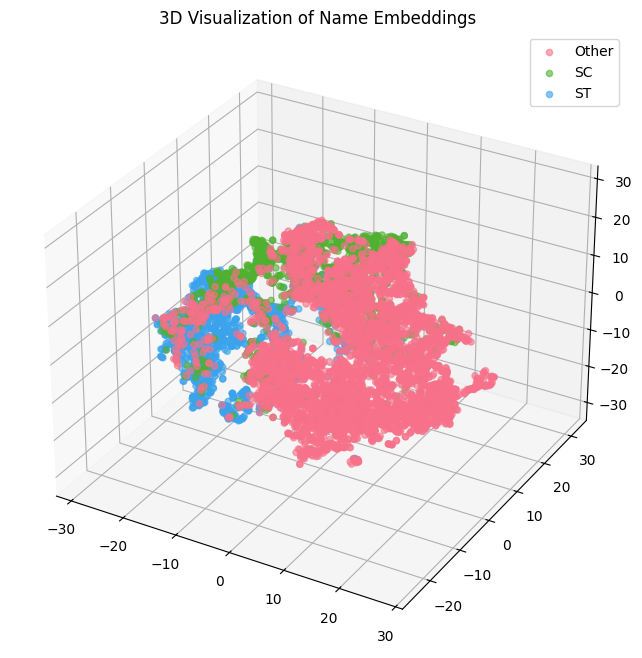

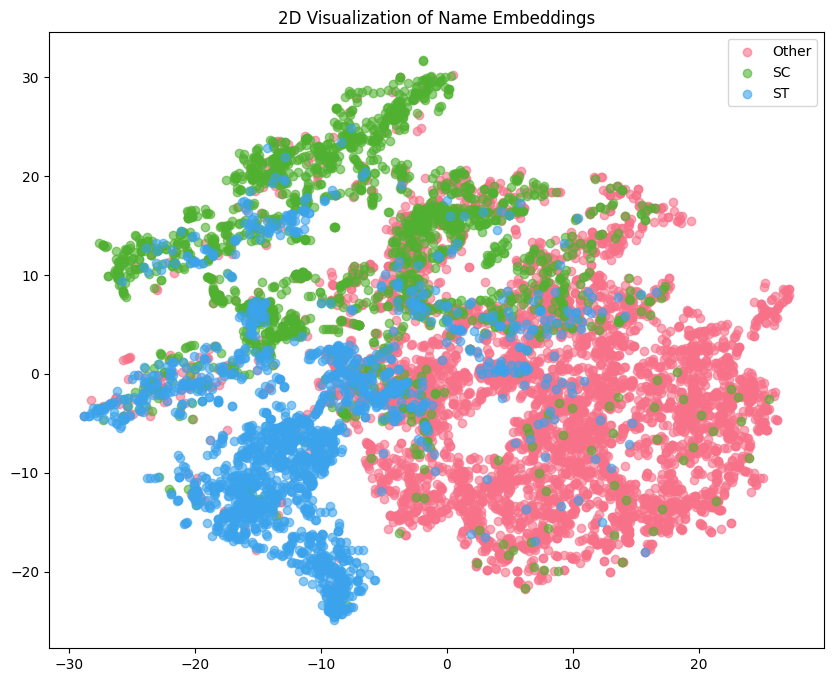

In [64]:
X_train, X_test, y_train, y_test, weights = process_data(df)

C:\Users\karnav\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


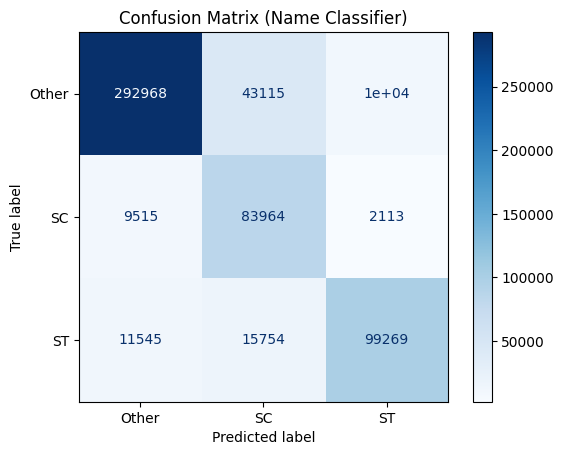


Name Classifier
Accuracy: 0.8377478317470929
Precision: 0.8652879834306653
Recall: 0.8377478317470929
F1: 0.8446465958102414


In [65]:
model = name_classifier(df, X_train, X_test, y_train, y_test, weights)